In [ ]:
!pip install tensorflow_federated

In [ ]:
!pip install privacy_meter
!pip install opacus

In [ ]:
import tensorflow as tf
import tensorflow_federated as tff

from privacy_meter.audit import Audit, MetricEnum
from privacy_meter.constants import InferenceGame
from privacy_meter.dataset import Dataset
from privacy_meter.information_source import InformationSource
from privacy_meter.model import TensorflowModel
from privacy_meter.audit_report import ROCCurveReport, SignalHistogramReport
from privacy_meter import audit_report

In [ ]:
# Load and preprocess your dataset
(train_images_all, train_labels_all), (test_images_all, test_labels_all) = tf.keras.datasets.cifar10.load_data()
split = 1000
number_of_points_for_training = 10000
number_of_points_for_test = 10000

train_images = train_images_all[:number_of_points_for_training]
train_labels = train_labels_all[:number_of_points_for_training]
test_images = test_images_all[:number_of_points_for_test]
test_labels = test_labels_all[:number_of_points_for_test]

# normalize samples
train_images, test_images = train_images / 255.0, test_images / 255.0

# Audit
num_reference_models = 8
fpr_tolerance_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Federation
num_clients = 5
num_rounds = 150

In [ ]:
def preprocess(dataset):
    def batch_format_fn(element):
        return (tf.expand_dims(element['x'], -1), element['y'])
    return dataset.batch(64).map(batch_format_fn)

def make_federated_data(images, labels, num_clients):
    """Creates a federated dataset from images and labels."""
    client_data = []
    total_data = len(images)
    client_data_size = total_data // num_clients
    for client_id in range(num_clients):
        start = client_id * client_data_size
        end = (client_id + 1) * client_data_size if client_id != num_clients - 1 else total_data
        client_data.append(
            tf.data.Dataset.from_tensor_slices(
                {'x': images[start:end], 'y': labels[start:end]}
            )
        )
    return [preprocess(data) for data in client_data]


In [ ]:
def create_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [ ]:
federated_train_data = make_federated_data(train_images[:split], train_labels[:split], num_clients)
# federated_test_data = preprocess(tf.data.Dataset.from_tensor_slices({'x': test_images[:split], 'y': test_labels[:split]}).batch(64))

In [ ]:
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.1),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.9)
)

In [ ]:
state = iterative_process.initialize()

In [ ]:
for round_num in range(num_rounds):
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f'Round {round_num + 1}, Metrics={metrics}')

Round 1, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.096), ('loss', 2.3114436), ('num_examples', 1000), ('num_batches', 18)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.13), ('loss', 2.2899399), ('num_examples', 1000), ('num_batches', 18)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.142), ('loss', 2.2775512), ('num_examples', 1000), ('num_batches', 18)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict(

In [ ]:
final_model_weights = iterative_process.get_model_weights(state)
trained_model = create_keras_model()
final_model_weights.assign_weights_to(trained_model)

In [ ]:
train_ds_target = {'x': train_images[:split], 'y': train_labels[:split]}
test_ds_target = {'x': test_images[:split], 'y': test_labels[:split]}

train_ds = {'x': train_images[split:], 'y': train_labels[split:]}
test_ds = {'x': test_images[split:], 'y': test_labels[split:]}

dataset = Dataset(
    data_dict={'train': train_ds, 'test': test_ds},
    default_input='x', default_output='y'
)

dataset_target = Dataset(
    data_dict={'train': train_ds_target, 'test': test_ds_target},
    default_input='x', default_output='y'
)

In [ ]:
datasets_list = dataset.subdivide(
    num_splits=num_reference_models + 1,
    delete_original=True,
    in_place=False,
    return_results=True,
    method='hybrid',
    split_size={'train': split, 'test': split}
)

In [ ]:
target_model = TensorflowModel(model_obj=trained_model, loss_fn=tf.keras.losses.SparseCategoricalCrossentropy())

In [ ]:
reference_models = []
for model_idx in range(num_reference_models):
    print(f"Training reference model {model_idx}...")
    reference_model = create_keras_model()
    reference_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    reference_model.fit(
        datasets_list[model_idx + 1].get_feature('train', '<default_input>'),
        datasets_list[model_idx + 1].get_feature('train', '<default_output>'),
        batch_size=64,
        epochs=60,
        verbose=2
    )
    reference_models.append(
        TensorflowModel(model_obj=reference_model, loss_fn=tf.keras.losses.SparseCategoricalCrossentropy())
    )

Training reference model 0...
Epoch 1/60
16/16 - 2s - loss: 2.3011 - accuracy: 0.1160 - 2s/epoch - 113ms/step
Epoch 2/60
16/16 - 1s - loss: 2.2034 - accuracy: 0.1860 - 994ms/epoch - 62ms/step
Epoch 3/60
16/16 - 1s - loss: 2.0594 - accuracy: 0.2770 - 994ms/epoch - 62ms/step
Epoch 4/60
16/16 - 1s - loss: 1.9565 - accuracy: 0.2770 - 1s/epoch - 75ms/step
Epoch 5/60
16/16 - 2s - loss: 1.8912 - accuracy: 0.3310 - 2s/epoch - 111ms/step
Epoch 6/60
16/16 - 2s - loss: 1.7980 - accuracy: 0.3520 - 2s/epoch - 112ms/step
Epoch 7/60
16/16 - 2s - loss: 1.7342 - accuracy: 0.3910 - 2s/epoch - 109ms/step
Epoch 8/60
16/16 - 2s - loss: 1.6829 - accuracy: 0.4180 - 2s/epoch - 112ms/step
Epoch 9/60
16/16 - 1s - loss: 1.6226 - accuracy: 0.4140 - 1s/epoch - 71ms/step
Epoch 10/60
16/16 - 1s - loss: 1.5941 - accuracy: 0.4430 - 988ms/epoch - 62ms/step
Epoch 11/60
16/16 - 1s - loss: 1.5264 - accuracy: 0.4540 - 998ms/epoch - 62ms/step
Epoch 12/60
16/16 - 1s - loss: 1.5150 - accuracy: 0.4700 - 996ms/epoch - 62ms/step

In [ ]:
target_info_source = InformationSource(
    models=[target_model],
    datasets=[dataset_target]
)

reference_info_source = InformationSource(
    models=reference_models,
    datasets=[dataset_target]
)

In [ ]:
audit_obj = Audit(
    metrics=MetricEnum.REFERENCE,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    fpr_tolerances=fpr_tolerance_list
)
audit_obj.prepare()

In [ ]:
audit_results = audit_obj.run()[0]
for result in audit_results:
    print(result)

Results are stored in: ['/content/log_2024-08-19_14-13-01-000']
============= METRIC RESULT OBJECT =============
Accuracy          = 0.5
ROC AUC Score     = 0.8156909999999999
FPR               = 0.0
TN, FP, FN, TP    = (1000, 0, 1000, 0)

============= METRIC RESULT OBJECT =============
Accuracy          = 0.742
ROC AUC Score     = 0.8156909999999999
FPR               = 0.159
TN, FP, FN, TP    = (841, 159, 357, 643)

============= METRIC RESULT OBJECT =============
Accuracy          = 0.7495
ROC AUC Score     = 0.8156909999999999
FPR               = 0.246
TN, FP, FN, TP    = (754, 246, 255, 745)

============= METRIC RESULT OBJECT =============
Accuracy          = 0.7525
ROC AUC Score     = 0.8156909999999999
FPR               = 0.318
TN, FP, FN, TP    = (682, 318, 177, 823)

============= METRIC RESULT OBJECT =============
Accuracy          = 0.737
ROC AUC Score     = 0.8156909999999999
FPR               = 0.394
TN, FP, FN, TP    = (606, 394, 132, 868)

============= METRIC RESULT OB

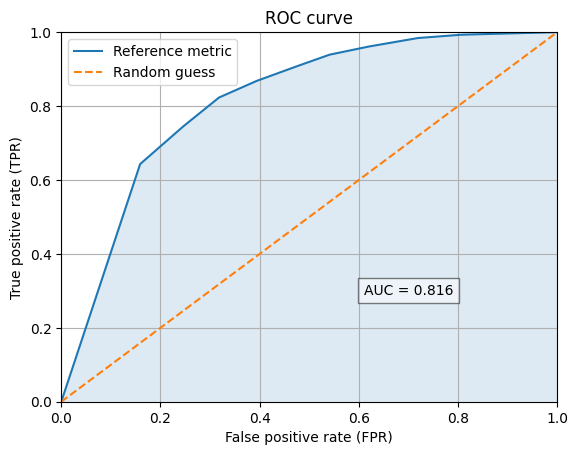

AUC = 0.816


<Figure size 640x480 with 0 Axes>

In [ ]:
ROCCurveReport.generate_report(
    metric_result=audit_results,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

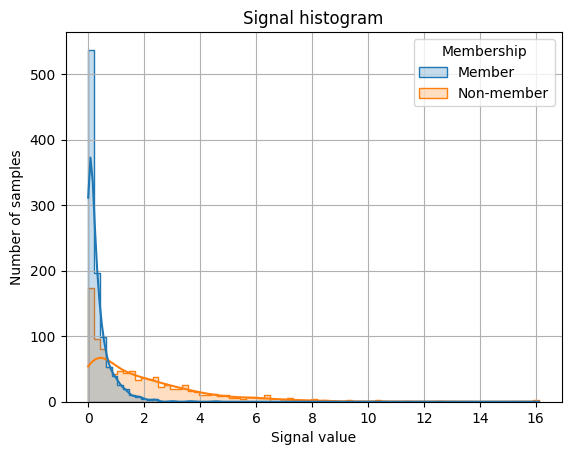

<Figure size 640x480 with 0 Axes>

In [ ]:
SignalHistogramReport.generate_report(
    metric_result=audit_results[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)